Here we will look at some aggregations over specific start and stop locations. Going from point A to point B is a 'trip'.

Grouping statistics by trip can cut the data size by a large amount, as the number of trips:
${n \choose 2}^2 $ (choosing pickups and dropoffs). 

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from scipy.stats import gaussian_kde
sns.set()

from datetime import datetime, timedelta

from Fair_Fare.feature_utils import load_hdf
from Fair_Fare.aggregations import bin_on_time_distance
from Fair_Fare.model_utils import get_model_from_file, predict_fare
from Fair_Fare.trips import Stop, Ride
from Fair_Fare.api_interactions import price_estimate_from_lyft

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
models = {"path":"models/", "taxi":"taxi_xgb_full", "rideshare":"tnp_xgb_full_reduced_params" }
data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

taxi_model = get_model_from_file(models['path']+models['taxi'])
taxi_data = load_hdf(data['path']+data['taxi'])

rideshare_model = get_model_from_file(models['path']+models['rideshare'])
rideshare_data = load_hdf(data['path']+data['rideshare'])

So there are about 900 unique lat/longs giving ~ 500k trip combinations.

#### Grouping by rides:

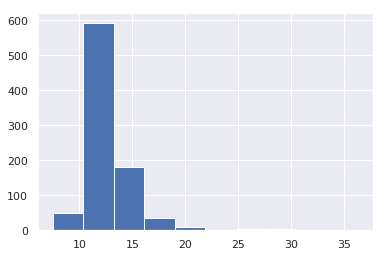

In [213]:
binned = bin_on_trips(rideshare_data)
binned.df.groupby(["Pickup_Centroid_Latitude","Pickup_Centroid_Longitude"]).Final_Fare.mean().hist()

In [214]:
# total unique trips with binning after the cut
binned.cut_along_lat_long()
print(binned.total_unique_paths)
trip_df = binned.df.groupby('path')

20253


In [ ]:
trip_df.head()

TODO: Create a function to plot the route on a map and show this histogram at the same time. Intermediate data product is a histogram for each of these routes.

In [77]:

test_trip = binned.df[binned.df['Final_Fare']>40].iloc[228]
#print(test_trip)
tup = ((test_trip['Pickup_Centroid_Latitude'],test_trip['Pickup_Centroid_Longitude']),
       (test_trip['Dropoff_Centroid_Latitude'],test_trip['Dropoff_Centroid_Longitude']))

assert binned.trip_to_path(tup) == test_trip['path']
print(test_trip)

Trip_Seconds                                   3761
Trip_Miles                                     19.4
Pickup_Community_Area                            33
Dropoff_Community_Area                           76
Shared_Trip_Authorized                        False
Pickup_Centroid_Latitude                    41.8593
Pickup_Centroid_Longitude                  -87.6174
Dropoff_Centroid_Latitude                   41.9791
Dropoff_Centroid_Longitude                  -87.903
vel_mph                                     18.5695
Final_Fare                                     42.5
l2_dist_km                                  27.1279
x_dist_km                                   23.6591
y_dist_km                                   13.3124
bearing                                    -60.5163
bAirport                                      False
day_of_wk                                         4
hour                                             14
Pickup_Centroid_Latitude_b                       10
Dropoff_Cent

We want a function that takes a single ride as input,
outputs the histogram and the prediction.

In [143]:
time = datetime.now()
time = time+ timedelta(hours=int(test_trip["hour"]+24)- time.hour) # replace time with hour tomorrow (gmaps pred must be in future)
ride = Ride(tup[0],tup[1], time = time, bRideshare = True, bShared = False)
predict_fare(ride, rideshare_model)

13.775015678965612 27.172984061071134
24.75999061088577 0.6476825405035734


array([50.357998], dtype=float32)

In [108]:
time = datetime.now()
time = time+ timedelta(hours=int(test_trip["hour"]+24)- time.hour)

In [232]:
binned = bin_on_time_distance(rideshare_data)


def text_to_fares(start, end, bRideshare = True, bShared = False):
    time = datetime.now()
    time = time#+ timedelta(hours=int(test_trip["hour"]+24)- time.hour)
    
    ride = Ride(start,end, time, bRideshare, bShared)
    Fair_Fare = predict_fare(ride, rideshare_model)
    lyft_estimates = price_estimate_from_lyft(ride.start.tuple,ride.end.tuple)
    td_tup = (ride.traveltime,ride.miles)
    binned_pth = binned.time_distance_to_bin(td_tup)
    group =  binned.df[binned.df.td_bin == binned_pth]
    return Fair_Fare, lyft_estimates, group

In [233]:
 Fair_Fare, lyft_estimates, group= text_to_fares("the bean chicago", "sears tower")

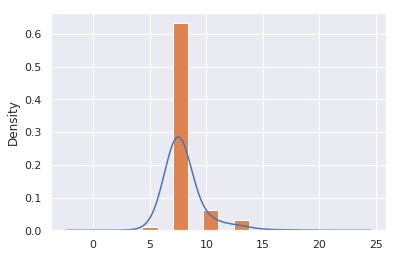

In [282]:
test_grp = group[group["Shared_Trip_Authorized"] == False].Final_Fare

test_grp.plot.kde(.8)
test_grp.hist(bins= 10, density = True)

In [286]:
data = group[group["Shared_Trip_Authorized"] == False].Final_Fare
def hist_and_kde(data, nbins = 20):
    gkde=gaussian_kde(data,bw_method = .8)
    grid = np.linspace(0,20,100)
    kde_vals = gkde.evaluate(grid)
    hist, bin_edges = np.histogram(data,nbins, density = True)
    return kde_vals,grid, hist, bin_edges

In [287]:
kde_test,grid,_,_ = hist_and_kde(test_grp)
kde_test = pd.DataFrame({'x':grid, 'y':kde_test})

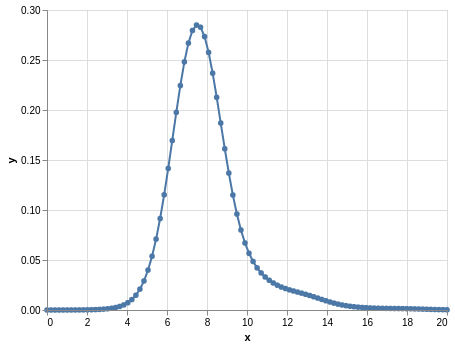

In [288]:
import altair as alt
import numpy as np
import pandas as pd

x = np.arange(10)/10
source = kde_test

alt.Chart(source).mark_line(point=True).encode(
    x='x',
    y='y'
)

In [54]:
MAX_MILES = 100
MAX_TIME = 7200

#mile_grid = np.

seconds = rideshare_data.Trip_Seconds.values

miles = rideshare_data.Trip_Miles.values

[ 0.1         0.60000002  0.80000001  1.          1.10000002  1.20000005
  1.29999995  1.39999998  1.60000002  1.70000005  1.89999998  2.
  2.20000005  2.4000001   2.5         2.70000005  3.          3.20000005
  3.4000001   3.70000005  3.9000001   4.30000019  4.5999999   4.9000001
  5.30000019  5.80000019  6.30000019  6.9000001   7.69999981 10.
 13.18499985 16.36999969 19.55499954 22.73999939 25.92499924 29.10999908
 32.29499893 35.47999878 38.66499863 41.84999847 45.03499832 48.21999817
 51.40499802 54.58999786 57.77499771 60.95999756 64.14499741 67.32999725
 70.5149971 ]


(0, 10)

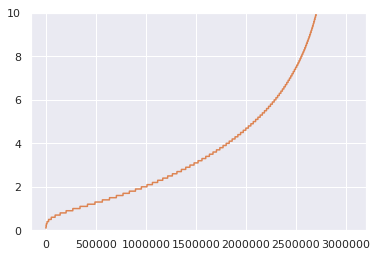

In [146]:
# choose the bin parameters based on an ad-hoc histogrm cutoff
#rideshare_data.Trip_Seconds.hist(bins = 100, range = (0,2000))
rideshare_data.Trip_Miles.hist(bins = 10, range = (0,60))

miles_bin = bin_on_counts(miles,nbins = 30, cutoff = 10)
print(miles_bin)
plt.plot(np.sort(rideshare_data.Trip_Miles.values))
plt.ylim([0,10])

In [114]:
rideshare_data["seconds_b"] = pd.cut(rideshare_data["Trip_Seconds"], bins = seconds_bin, labels = np.arange(len(seconds_bin)-1), retbins=False)

In [148]:
from Fair_Fare.aggregations import bin_on_time_distance

In [159]:
dd = bin_on_time_distance(rideshare_data)

In [182]:
dd.df.miles_b.isna().sum()

937

In [167]:
30*50

1500